In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import random

from sklearn.model_selection import train_test_split

## Dowload the dataset and explore

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir=".", untar=True)

In [3]:
data_dir

'.\\datasets\\flower_photos'

In [4]:
# check files inside folders

real_data_dir = os.path.join(data_dir, "flower_photos")
print(os.listdir(real_data_dir))

for class_name in os.listdir(real_data_dir):
    class_path = os.path.join(real_data_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len([f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        print(f"{class_name}: {num_files} images")

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']
daisy: 633 images
dandelion: 898 images
roses: 641 images
sunflowers: 699 images
tulips: 799 images


In [5]:
real_data_dir = pathlib.Path(real_data_dir)
print(real_data_dir)

image_count = len(list(real_data_dir.glob("*/*.jpg")))
print("Total images count: ", image_count)

datasets\flower_photos\flower_photos
Total images count:  3670


In [6]:
roses = list(real_data_dir.glob("roses/*"))
roses[:5]

[WindowsPath('datasets/flower_photos/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

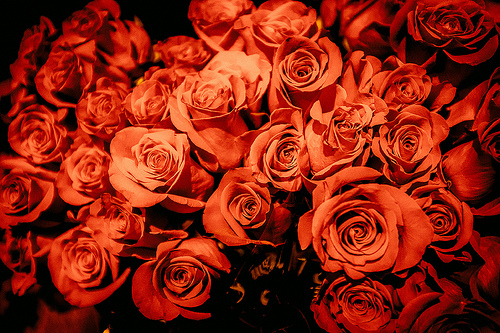

In [7]:
# show some images

PIL.Image.open(str(roses[2]))

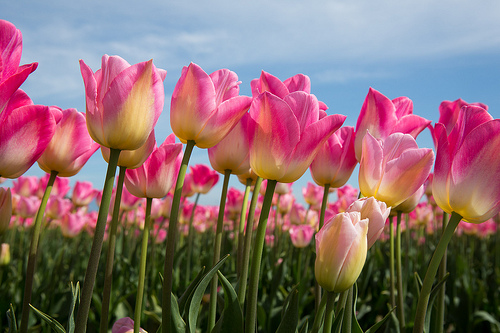

In [8]:
tulips = list(real_data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[3]))

In [9]:
# dictionary with paths to different flowers

flowers_images_dict = {
    "roses": list(real_data_dir.glob("roses/*")),
    "daisy": list(real_data_dir.glob("daisy/*")),
    "dandelion": list(real_data_dir.glob("dandelion/*")),
    "sunflowers": list(real_data_dir.glob("sunflowers/*")),
    "tulips": list(real_data_dir.glob("tulips/*"))
}

In [10]:
# I assign a class number to each of these flowers

flowers_labels_dict = {
    "roses": 0,
    "daisy": 1,
    "dandelion": 2,
    "sunflowers": 3,
    "tulips": 4
}

In [11]:
img = cv2.imread(str(flowers_images_dict["roses"][0]))
img

array([[[ 0, 15,  6],
        [ 0, 15,  6],
        [ 0, 17,  8],
        ...,
        [24, 51, 31],
        [25, 52, 32],
        [26, 53, 33]],

       [[ 7, 22, 14],
        [ 7, 22, 14],
        [ 6, 21, 13],
        ...,
        [20, 46, 30],
        [23, 49, 33],
        [25, 51, 35]],

       [[12, 23, 15],
        [12, 23, 15],
        [11, 22, 14],
        ...,
        [20, 42, 30],
        [23, 45, 33],
        [26, 48, 36]],

       ...,

       [[19, 30, 27],
        [14, 24, 18],
        [12, 20, 13],
        ...,
        [ 4, 13,  3],
        [ 0,  8,  1],
        [ 0,  5,  0]],

       [[19, 30, 28],
        [18, 27, 24],
        [15, 23, 16],
        ...,
        [ 3, 12,  2],
        [ 1,  9,  2],
        [ 0,  7,  2]],

       [[ 9, 19, 19],
        [17, 25, 24],
        [22, 29, 24],
        ...,
        [ 1, 12,  2],
        [ 2, 10,  3],
        [ 3, 11,  4]]], shape=(240, 179, 3), dtype=uint8)

In [12]:
img.shape

(240, 179, 3)

cv2 converts the image in a 3 dimensional numpy array (x, y, 3 RGB channels).

I also need to resize images, because they all have different dimensions. Dimensions must be the same for all the images.

In [13]:
cv2.resize(img,(180, 180)).shape

(180, 180, 3)

In [35]:
# prepare X and y

X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:

        if image.suffix.lower() not in (".jpg", ".jpeg", ".png"):
            continue
             
        img = cv2.imread(str(image))

        if img is None:
            print(f"File non leggibile: {image}")
            continue
            
        resized_img = cv2.resize(img,(180, 180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [36]:
X = np.array(X)
y = np.array(y)

## Training

In [37]:
# Split testing and trqining data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

print(f"Data for training: {len(X_train)}; for testing: {len(X_test)}")

Data for training: 3303; for testing: 367


In [38]:
# Scaling

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [42]:
# CNN

model = Sequential([

    # Convolutional layers
    layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=(180,180,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    # Dense layers
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(flowers_images_dict))
])

In [45]:
# compile the model

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# train

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4372 - loss: 1.3461
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6267 - loss: 0.9647
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6836 - loss: 0.8204
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7648 - loss: 0.6482
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8565 - loss: 0.4268
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8980 - loss: 0.2942
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9431 - loss: 0.1798
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9667 - loss: 0.1083
Epoch 9/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9867 - loss: 0.0494
Epoch 10/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9882 - loss: 0.0450
Epoch 11/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9876 - loss: 0.0518
Epoch 12/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 

## Testing

In [50]:
model.evaluate(X_test_scaled, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6158 - loss: 3.8237


[3.8236758708953857, 0.6158038377761841]

*Overfitting!* only 61% of accuracy.

In [51]:
predictions = model.predict(X_test_scaled)
predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[ 1.8368227e+00, -9.0794210e+00, -2.2197759e+00,  3.9069884e+00,
        -1.8551934e+00],
       [-2.7532284e+00, -1.0977335e+01,  3.7102098e+00,  1.3361784e+01,
         1.7379043e+00],
       [-4.1594543e+00, -3.6454980e+00, -3.2123792e+00,  7.4044404e+00,
         8.1133321e-03],
       ...,
       [ 7.0750232e+00, -4.6689091e+00, -6.6390519e+00,  2.1516285e+00,
         2.3654206e+00],
       [ 1.0832944e+01, -9.3798389e+00, -1.6328948e+00, -5.8849564e+00,
         5.4926926e-01],
       [-1.0468695e+01,  1.7034086e+00,  2.0284893e+01, -1.6713774e+01,
        -1.4874832e+01]], shape=(367, 5), dtype=float32)

## Data augmentation

To reduce the overfitting. There are different types of transformations that I can apply.

In [61]:
data_augmentation = keras.Sequential([
    #layers.RandomZoom(0.3)
    #layers.RandomContrast(0.9)
    layers.RandomRotation(0.9)
])

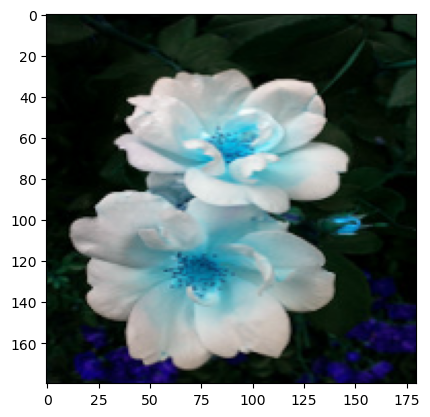

In [62]:
# example of random zoom

plt.imshow(X[0])

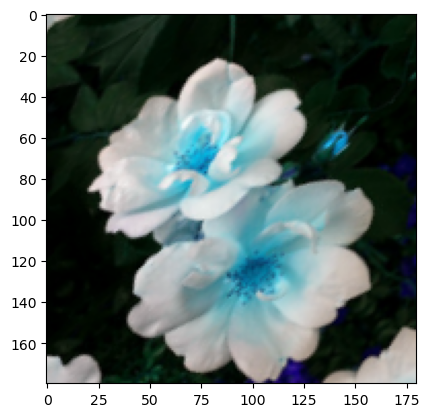

In [63]:
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

In [66]:
# I am going to use several transformations for my model

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [68]:
# CNN and compile

model = Sequential([

    data_augmentation,

    # Convolutional layers
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.2), 

    # Dense layers
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(flowers_images_dict))
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [69]:
model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.4332 - loss: 1.3281
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5689 - loss: 1.0654
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6149 - loss: 0.9786
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6652 - loss: 0.8827
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6863 - loss: 0.8156
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7097 - loss: 0.7751
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7142 - loss: 0.7392
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7187 - loss: 0.7099
Epoch 9/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7387 - loss: 0.6699
Epoch 10/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7523 - loss: 0.6507
Epoch 11/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7654 - loss: 0.6233
Epoch 12/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 

In [70]:
# test

model.evaluate(X_test_scaled, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7520 - loss: 0.7584


[0.7584049701690674, 0.752043604850769]

With data augmentation, I was able to bring accuracy from 61% to 75% :)